In [63]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [64]:
import numpy as np

class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        self.p = self.m*self.v
        self.f = self.m*self.a
        
        # Historial
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        self.F = np.zeros_like(self.R)
        self.P = np.zeros_like(self.R)
        
        # Fisica
        self.K = 20.
        self.VEk = np.zeros(len(t))
        
        # Gravedad
        self.gravity = np.array([0, -9.8])  # Aceleración debida a la gravedad
    
    def Evolution(self, i):
        self.SetPosition(i)
        self.SetVelocity(i)
        
        # Actualizar aceleración con la gravedad
        self.a = self.f / self.m + self.gravity
        
        # Euler-Cromer
        self.v += self.dt * self.a
        self.r += self.dt * self.v
        
    def CalculateForce(self, p):
        d = np.linalg.norm(self.r - p.r)
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            Fn = self.K * compresion**3
            self.n = (self.r - p.r) / d     
            self.f = np.add(self.f, Fn * self.n)
            # Falta implementar energía potencial 
            
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
    
    def SetPosition(self, i):
        self.R[i] = self.r
    
    def SetVelocity(self, i):
        self.V[i] = self.v
        self.P[i] = self.m * self.v
        self.VEk[i] = 0.5 * self.m * np.dot(self.v, self.v)
    
    def GetPosition(self, scale=1):
        return self.R[::scale]
    
    def GetVelocity(self, scale=1):
        return self.V[::scale]
 
    def GetMomentum(self, scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self, scale=1):
        return self.VEk[::scale] 
    
    def CheckLimits(self):
        for i in range(2):
            if self.r[i] + self.radius > 20 and self.v[i] > 0.:
                self.v[i] = -self.v[i] * 0.9
            elif self.r[i] - self.radius < -20 and self.v[i] < 0.:
                self.v[i] = -self.v[i] * 0.9
                
    


In [65]:
def GetParticles(N,t):
    
    r0 = np.array([-15.,-10.])
    v0 = np.array([2.,0])
    a0 = np.array([0.,0.])
    
    p0 = Particle(r0,v0,a0,t,m=1,radius=2,Id=0)
    
    Particles = [p0]
    
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    
    return Particles

In [66]:
dt = 0.001
tmax = 30
t = np.arange(0,tmax,dt)
Particles = GetParticles(1,t)

In [67]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [68]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 30000/30000 [00:00<00:00, 40459.33 Steps/s]


In [69]:
# Bajamos dimensión de la simulacion
scale = 100
t1 = t[::scale]

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

In [71]:
#Animation.save('Rebote.gif', writer='pillow',fps=30)

In [72]:
MomentumT = Particles[0].GetMomentum(scale)

In [73]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))

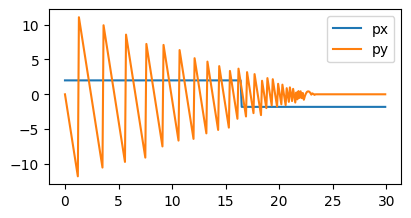

In [74]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(221)
ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax3.legend()

### Grafica distancia 'y' en funcion del tiempo



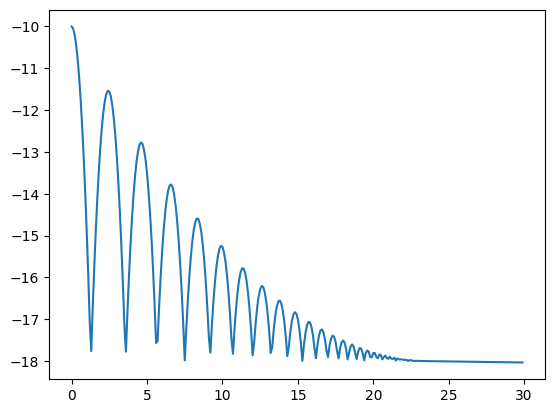

In [75]:
distancia=Particles[0].GetPosition(scale)

plt.plot(t1,distancia[:,1])
plt.show()

Como se puede observar en la grafica alrededor del segundo 23 la pelota deja de rebotar

### Calculo del amortiguamiento



In [81]:

y=distancia[:,1]
puntos_maximos=[y[0]]
for i in range(1,len(y)):
    
    if y[i-1] < y[i] and y[i+1] < y[i]:
        puntos_maximos.append(y[i])
        break
    
amortigamiento = ((puntos_maximos[0]/puntos_maximos[1]))**0.5
    
print(f'El amortiguamiento es aproximadamente:{amortigamiento} ')

El amortiguamiento es aproximadamente:0.9310388039444714 


### Punto 4

Punto e sin runge kutha

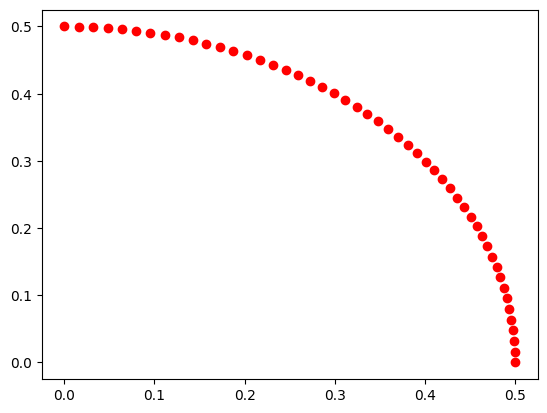

In [83]:
theta=np.linspace(np.pi/2,0,50)

y=0.5*np.cos(theta)

x=0.5*np.sin(theta)

plt.scatter(x,y,color='r')

Punto F

In [98]:
def System(r,t,g,L):
    
    dthetadt=r[1]
    
    dtheta2dt=(((2*g/L)- dthetadt**2 * np.cos(t))*np.sin(t)) / ((1/3)+np.sin(t)**2)
     
    return[dthetadt,dtheta2dt]


def Integrator2(f,r,t,g,L):

    h = t[1] - t[0]
    
    theta = np.zeros_like(t)
    v_theta = np.zeros_like(t)

    theta[0] = r[0]
    v_theta[0] = r[1]
    
    K1 = np.zeros(2)
    K2 = np.zeros(2)
    
    # Las pendientes instantaneas
    R = np.zeros(2)

    for i in range(1,len(t)):
        
        R = np.array([theta[i-1],v_theta[i-1]])
        
        K1 = f(R,t[i-1],g,L)
        R = np.array([theta[i-1]+h*K1[0],v_theta[i-1]+h*K1[1]])
        
        K2 = f(R,t[i-1]+h,g,L)
        
        theta[i] = theta[i-1] + 0.5*h*(K1[0]+K2[0])
        v_theta[i] = v_theta[i-1] + 0.5*h*(K1[1]+K2[1])
        
        
    return x,y


In [97]:
t=np.linspace(0,10000,1000)
r0=[np.pi/18,0]
theta,v_theta=Integrator2(System,r0,t,9.8,1)


C:\Users\Sebastian Hurtado\AppData\Local\Temp\ipykernel_23808\2274959670.py:5: RuntimeWarning: overflow encountered in scalar power
  dtheta2dt=(((2*g/L)-dthetadt**2 * np.cos(t))*np.sin(t))/((1/3)+np.sin(t)**2)
C:\Users\Sebastian Hurtado\AppData\Local\Temp\ipykernel_23808\2274959670.py:36: RuntimeWarning: invalid value encountered in scalar add
  v_theta[i] = v_theta[i-1] + 0.5*h*(K1[1]+K2[1])


#### Punto e con rungekutha

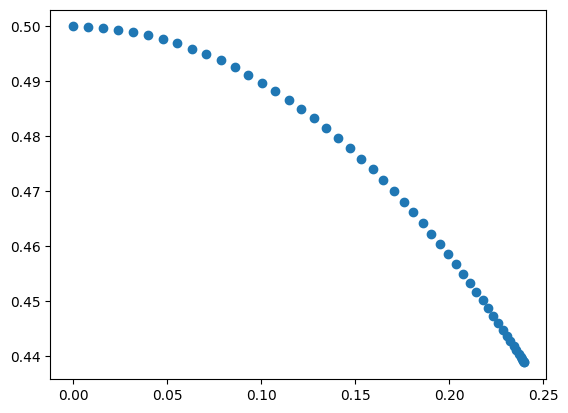

In [95]:
y=0.5*np.cos(theta)
x=0.5*np.sin(theta)
plt.scatter(x,y)